In [ ]:
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

CGAN (Conditional GAN) - GAN который учится не только на изображениях, но и на присущих им метках. Таким образом, можно реализовать генерацию с условиями (на датасете MNIST - задать число, а модель сгенерирует картинку с ним).

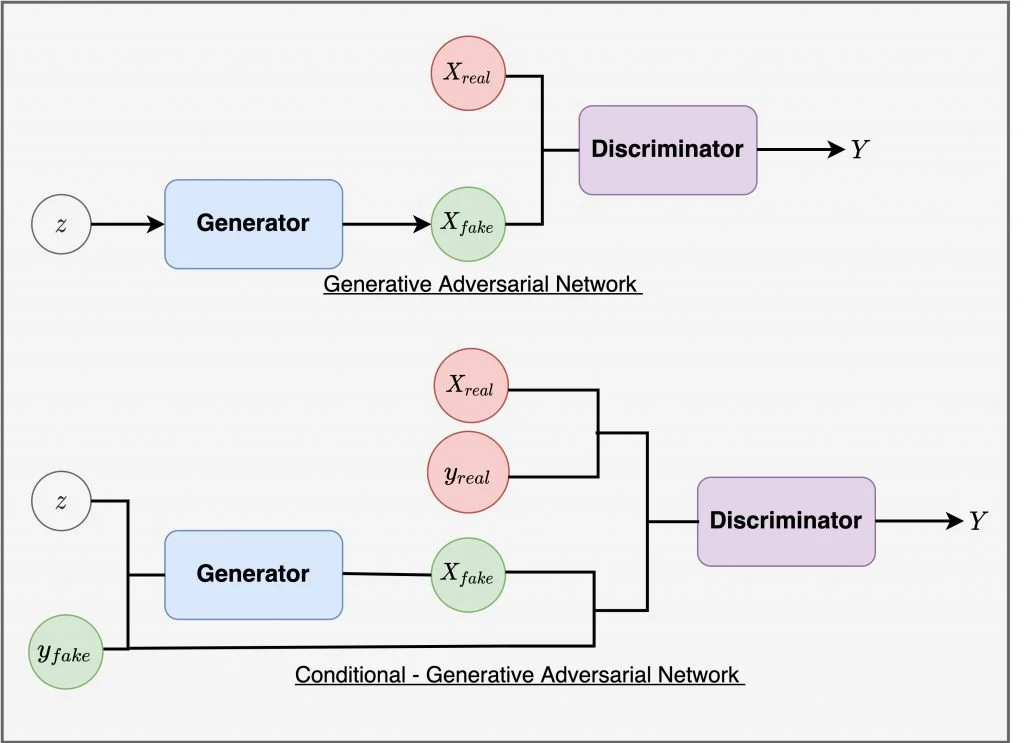

## Загрузка данных

In [ ]:
dataset  = datasets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.Compose(
                                  [transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
                                  ]),
                            download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Метод для генерации рандомного шума (вход в генератор)

In [ ]:
def random_noise(batch_size):
    n = torch.randn(batch_size, 100)
    return n.to(device)

Метод для показа изображений (много преобразовательной магии, не вникайте в этот метод пожалуйста)

In [ ]:
def visualise(imgs, rows=2):
    imgs = imgs.view(-1, 1, 28, 28)
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = np.squeeze((torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1])
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Модули

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 794 # прибавить 10
        n_out = 1
        self.label_emb = nn.Embedding(10, 10) # добавить слой
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x, labels): # добавить метки
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)

        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 110 # прибавить 10
        n_out = 784

        self.label_emb = nn.Embedding(10, 10) # добавить слой
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x, labels): # добавить метки
        c = self.label_emb(labels) 
        x = torch.cat([x, c], 1) # конкатенируем все вектора
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [ ]:
discriminator = Discriminator()
generator = Generator()
discriminator.to(device)
generator.to(device)

Generator(
  (label_emb): Embedding(10, 10)
  (hidden0): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

## Оптимизация и функция потерь

In [ ]:

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

d_steps = 1 
num_epochs = 200

## Методы для обчуения генератора и дискриминатора

In [ ]:
def train_discriminator(optimizer, real_data, fake_data, fake_labels, labels): # добавили аргументы
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data, labels) # добавили тру лейблы

    real_data_target = torch.ones(real_data.size(0), 1)
    real_data_target = real_data_target.to(device)

    error_real = loss(prediction_real, real_data_target)
    error_real.backward()


    prediction_fake = discriminator(fake_data, fake_labels) # добавили фейковые лейблы

    fake_data_target = torch.zeros(real_data.size(0), 1)
    fake_data_target =  fake_data_target.to(device)
    error_fake = loss(prediction_fake, fake_data_target)


    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data, fake_labels):
    optimizer.zero_grad()

    prediction = discriminator(fake_data, fake_labels) # добавить фейковые лейблы

    real_data_target = torch.ones(prediction.size(0), 1)
    real_data_target = real_data_target.to(device)
    
    error = loss(prediction, real_data_target)
    
    error.backward()
    optimizer.step()
    return error

In [ ]:
num_test_samples = 16
visualise_every = 10

### Начинаем обучение

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 | Discriminator loss: 1.134467177161326 | Generator loss: 1.8438979000474016


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 | Discriminator loss: 1.0917250427479546 | Generator loss: 2.053983144983649


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 | Discriminator loss: 1.0983081618448098 | Generator loss: 1.5594386054078737


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 | Discriminator loss: 0.9746714776257673 | Generator loss: 1.719627039283514


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 | Discriminator loss: 0.711345418492953 | Generator loss: 2.051761425336202


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6 | Discriminator loss: 0.6396723737816016 | Generator loss: 2.2947852392991384


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7 | Discriminator loss: 0.6660476414362589 | Generator loss: 2.224668417771657


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8 | Discriminator loss: 0.6090266255040964 | Generator loss: 2.41663319170475


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 9 | Discriminator loss: 0.6950190553069114 | Generator loss: 2.1309527917702993


  0%|          | 0/600 [00:00<?, ?it/s]

tensor([5, 0, 4, 4, 3, 3])


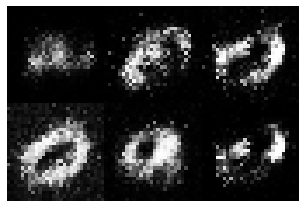

Epoch 10 | Discriminator loss: 0.7078927757342657 | Generator loss: 2.1869258091847104


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 11 | Discriminator loss: 0.7164204968512058 | Generator loss: 2.1332196591297787


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 12 | Discriminator loss: 0.7048912586271763 | Generator loss: 2.1348883324861525


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 13 | Discriminator loss: 0.7503293275336425 | Generator loss: 1.9767146972815195


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 14 | Discriminator loss: 0.7682119155923526 | Generator loss: 1.9138343075911204


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 15 | Discriminator loss: 0.7991669554511706 | Generator loss: 1.8719952903191248


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 16 | Discriminator loss: 0.8165196005503337 | Generator loss: 1.796091823776563


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 17 | Discriminator loss: 0.8216637926797072 | Generator loss: 1.8115266605218252


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 18 | Discriminator loss: 0.8251458224157492 | Generator loss: 1.790207683046659


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 19 | Discriminator loss: 0.8564865430196126 | Generator loss: 1.72700288494428


  0%|          | 0/600 [00:00<?, ?it/s]

tensor([2, 4, 8, 8, 5, 9])


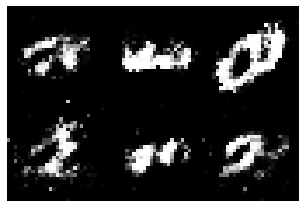

Epoch 20 | Discriminator loss: 0.8720349325736364 | Generator loss: 1.6533219182491303


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 21 | Discriminator loss: 0.9134919513265292 | Generator loss: 1.5733509957790375


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 22 | Discriminator loss: 0.9018902751803398 | Generator loss: 1.6050650067130725


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 23 | Discriminator loss: 0.9069302134712537 | Generator loss: 1.6237000666062038


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 24 | Discriminator loss: 0.9083816157778104 | Generator loss: 1.591881641348203


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 25 | Discriminator loss: 0.9444599143664042 | Generator loss: 1.5362219866116842


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 26 | Discriminator loss: 0.9552053584655126 | Generator loss: 1.4786356457074483


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 27 | Discriminator loss: 0.9598174952467282 | Generator loss: 1.4747165194153786


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 28 | Discriminator loss: 0.9763332485159238 | Generator loss: 1.4596058694521585


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 29 | Discriminator loss: 0.9934118084112803 | Generator loss: 1.403279088238875


  0%|          | 0/600 [00:00<?, ?it/s]

tensor([4, 3, 9, 9, 3, 4])


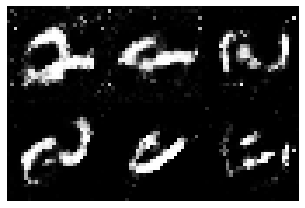

Epoch 30 | Discriminator loss: 1.009650509953499 | Generator loss: 1.3618002824982007


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 31 | Discriminator loss: 1.0503494448463122 | Generator loss: 1.2714115674297015


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 32 | Discriminator loss: 1.0797139379382132 | Generator loss: 1.2311692355076471


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 33 | Discriminator loss: 1.0884153617421786 | Generator loss: 1.206812017261982


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 34 | Discriminator loss: 1.094896900355816 | Generator loss: 1.2125463311870892


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 35 | Discriminator loss: 1.0917035178343455 | Generator loss: 1.1958262493213019


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 36 | Discriminator loss: 1.0961288825670878 | Generator loss: 1.1931562016407649


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 37 | Discriminator loss: 1.1262359709541003 | Generator loss: 1.1406453097860019


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 38 | Discriminator loss: 1.139822911421458 | Generator loss: 1.110746031800906


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 39 | Discriminator loss: 1.1392366197705268 | Generator loss: 1.1047324333588282


  0%|          | 0/600 [00:00<?, ?it/s]

tensor([1, 3, 0, 3, 2, 9])


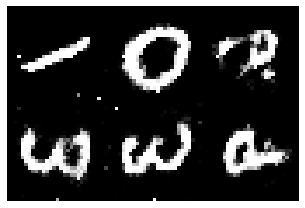

Epoch 40 | Discriminator loss: 1.1558078730106354 | Generator loss: 1.0926074856519699


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 41 | Discriminator loss: 1.1314704695343971 | Generator loss: 1.13011873314778


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 42 | Discriminator loss: 1.1427819018562635 | Generator loss: 1.1274421093861262


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 43 | Discriminator loss: 1.1747121038039525 | Generator loss: 1.0573656859993934


  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
for epoch in range(num_epochs):
    total_batches = 0
    gen_loss_avg = 0
    disc_loss_avg = 0
    for n_batch, (real_batch, labels) in tqdm(enumerate(data_loader), total=num_batches):

        total_batches += 1
        real_batch_size = real_batch.size(0)

        labels=labels.to(device) # загружаем на девайс
        real_data = real_batch.view(real_batch_size, 784) 
        real_data = real_data.to(device)

        fake_labels = torch.Tensor(np.random.randint(0, 10, real_batch_size)).to(torch.int64).to(device) # добавить генерацию фейковых лейблов
        fake_data = generator(random_noise(real_batch_size), fake_labels).detach() #не забываем подгрузить лейблы в генератор

        d_loss, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data, fake_labels, labels) # подгружаем оба типа лейблов
        disc_loss_avg += d_loss.item()


        fake_labels = torch.Tensor(np.random.randint(0, 10, real_batch_size)).to(torch.int64).to(device) # добавить генерацию фейковых лейблов
        fake_data = generator(random_noise(real_batch_size), fake_labels) # не забываем подгрузить лейблы в генератор

        g_loss = train_generator(g_optimizer, fake_data, fake_labels) # добавить аргумент с лейблами
        gen_loss_avg += g_loss.item()

    if (epoch + 1) % visualise_every == 0:
        with torch.no_grad():
            random_labels = torch.Tensor(np.random.randint(0, 10, 6)).to(torch.int64).to(device) # добавили случайные 6 лейблов
            print(random_labels)
            visualise(generator(random_noise(6), random_labels), rows=2)
    print(f"Epoch {epoch+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")
